In [1]:
import sys
sys.path.append("../")

# from src.dataloader.meta_loader import Dataloader4SER, NShotMAMLSampler
from src.audio.audio import AudioProcessor

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
'''
Dataloader for SER in meta-learning approach
'''

import numpy as np
import pandas as pd
import torch.utils.data as data
import torch
import random
from collections import defaultdict

# First we define a global dataloader which simply loads
# the pairs of wav files and emotion labels
class Dataloader4SER(data.Dataset):
    '''
        Given a csv file with wav_path and label columns,
        it returns pairs of raw wav_file path and labels.
    
        TODO: Process directly a disered audio transformation
        (instead of pass the raw wav path pass the melspectrogram or the mfccs)
    '''
    def __init__(self, df_path, ap, pad_to=100, pad_value = 0):
        self.df_path = df_path # Must have wav_path and labels columns
        self.ap = ap
        self.pad_to = pad_to
        self.pad_value = pad_value
        
        self.all_data = pd.read_csv(self.df_path) # Must be comma delimited

        cols = self.all_data.columns
        if('wav_path' not in cols):
            raise RuntimeError('There is no > wav_path < column.')

        if('emotion' not in cols):
            raise RuntimeError('There is no > emotion < column.')

        # if('language' not in cols):
        #     raise RuntimeError('There is no > language < column.')

        # If dataset is complete then get the lists 
        self.x = self.all_data['wav_path'].to_list()
        self.y = self.all_data['emotion'].to_list()
        # self.l = self.all_data['language'].to_list()

    def load_wav(self, filename):
        audio = self.ap.load_wav(filename)
        return audio

    def load_data(self, index):
        wav = self.x[index]
        emotion = self.y[index]

        # w = np.asarray(self.load_wav(wav), dtype=np.float32)
        w = self.load_wav(wav)

        mel = self.ap.melspectrogram(w).astype('float32')

        mel_lengths = mel.shape[1]


        # mel = prepare_tensor(mel, 1)
        mel = mel.transpose(1, 0)


        # log mel  
#         mel = np.log(mel)

        # pad mel
        if(mel_lengths >= self.pad_to):
            mel = mel[:self.pad_to, :]
        else:
            N = self.pad_to - mel_lengths
            zeros = np.ones((N,80))*self.pad_value
            mel = np.concatenate((mel, zeros), axis = 0)

        # print(mel.shape)


        mel = torch.FloatTensor(mel).contiguous()
        # mel_lengths = torch.LongTensor(mel_lengths)


        # return {'wav': w, 'emotion': np.asarray(emotion)}
        return {'mel': mel, 'emotion': emotion}

    def collate_fn(self, batch):

        # w = batch[:,0]
        # emotion = batch[:,1]
        # print(w, emotion)
        print(batch)

        mel = [self.ap.melspectrogram(w).astype("float32") for w in batch['wav']]
        # mel = self.ap.melspectrogram(w).astype('float32')
        mel_lengths = mel.shape[1]

        mel = prepare_tensor(mel, self.outputs_per_step)
        mel = mel.transpose(0, 2, 1)

        mel = torch.FloatTensor(mel).contiguous()
        mel_lengths = torch.LongTensor(mel_lengths)

        return {'melspec': mel, 'mel_len': mel_lengths, 'emotion': torch.tensor(batch['emotion'])}

    def __getitem__(self, index):
        return self.load_data(index)

    def __len__(self):
        return len(self.x)


class NShotMAMLSampler(object):
    '''
        NShotMAMLSampler returns batches of meta samples
        in a N-samples way of each class 
    '''

    def __init__(self, targets, n_way, k_shot, lang, n_episodes_per_iter, shuffle, shuffle_once, include_query):
        '''
          n_way: number of examples for each of the k classes
        '''
        self.targets = targets
        self.n_way = n_way
        self.k_shot = k_shot
        self.language = lang
        self.batch_size = n_way*k_shot
        self.episodes = n_episodes_per_iter
        self.shuffle = shuffle
        self.shuffle_once = shuffle_once
        self.include_query = include_query

        # Organize samples per target value
        self.classes = torch.unique(self.targets).tolist()
        self.num_classes = len(self.classes)

        self.idx_per_class = {}
        self.batches_per_class = {}

        for c in self.classes:
          self.idx_per_class[c] = torch.where(self.targets == c)[0]
          self.batches_per_class[c] = self.idx_per_class[c].shape[0]//self.k_shot


        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.n_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.idx_per_class[c].shape[0])
            self.idx_per_class[c] = self.idx_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.n_way:(it+1)*self.n_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.idx_per_class[c][start_index[c]:start_index[c]+self.k_shot])
                start_index[c] += self.k_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations
      

        

In [3]:
# Generating debug test csv to read from debug_wavs path

wav_path = "../data/debug_wavs/"

import os

os.listdir(wav_path)[:3]

['LJ001-0001.wav', 'LJ001-0002.wav', 'LJ001-0003.wav']

In [4]:
wavs = []
emotions = []

for i, wav in enumerate(os.listdir(wav_path)):
    wavs.append(wav_path + wav)
    emotions.append(i%6)#imod2 is a series of 0, 1, 2 and 3 just to simulate different emotions

In [5]:
import pandas as pd

df = pd.DataFrame({'wav_path': wavs, 'emotion': emotions})
df.to_csv("df.csv", index = False)
df.head()

,wav_path,emotion
0,../data/debug_wavs/LJ001-0001.wav,0
1,../data/debug_wavs/LJ001-0002.wav,1
2,../data/debug_wavs/LJ001-0003.wav,2
3,../data/debug_wavs/LJ001-0004.wav,3
4,../data/debug_wavs/LJ001-0005.wav,4


In [6]:
df.emotion.value_counts()

1    4
0    4
5    3
4    3
3    3
2    3
Name: emotion, dtype: int64

In [7]:
# Testing loader
N_WAY = 5
K_SHOT = 5
import torch.utils.data as data
import torch

ap = AudioProcessor(fft_size = 1024,
                    hop_length = 256,
                    win_length = 1024,
                    pad_wav=False,
                    num_mels = 80,
                    mel_fmin = 80,
                    mel_fmax = 7600,
                    sample_rate = 22050,
                    duration = None,
                    resample = True,
                    signal_norm= True,
                    ref_level_db = 20,
                    min_level_db = -100,
                    symetric_norm = True,
                    max_norm = 4)

dataset = Dataloader4SER('df.csv', ap, pad_to = 250, pad_value = -3)

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:True
 | > duration:None
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:True
 | > symmetric_norm:None
 | > mel_fmin:80
 | > mel_fmax:7600
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


In [8]:
dl = data.DataLoader(dataset)

In [9]:
batch = next(iter(dl))

In [10]:
batch

{'mel': tensor([[[0.5709, 0.7248, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.9525, 0.9890, 1.0505,  ..., 0.8029, 1.0163, 1.4931],
          [1.2422, 1.2814, 1.2081,  ..., 0.9865, 1.2055, 1.7462],
          ...,
          [1.1026, 1.1290, 1.1860,  ..., 0.0000, 0.0080, 0.0000],
          [1.2059, 1.1957, 0.8934,  ..., 0.0000, 0.0073, 0.0000],
          [1.0774, 0.9445, 0.9764,  ..., 0.0000, 0.0000, 0.0000]]]),
 'emotion': tensor([0])}

In [11]:
dataset.load_data(1)['mel'].detach().cpu().numpy()[-2]

array([-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3.], dtype=float32)

In [12]:
dataset.load_wav(dataset.x[0])

array([-7.3242188e-04, -7.6293945e-04, -6.4086914e-04, ...,
        7.3242188e-04,  2.1362305e-04,  6.1035156e-05], dtype=float32)

In [13]:
dataset.load_data(1)['mel'].shape

torch.Size([250, 80])

In [14]:
dataset.load_data(0)['mel'].detach().numpy().shape

(250, 80)

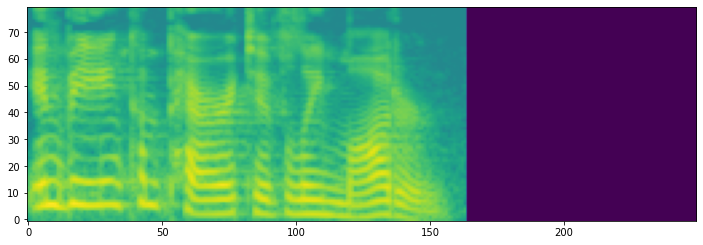

In [15]:
plt.figure(figsize=(12,7))
plt.imshow(dataset.load_data(1)['mel'].detach().cpu().numpy().T, origin = 'lower')

In [18]:
dataset.load_data(1)['mel'].detach().cpu().numpy().shape

(250, 80)

In [24]:
dataset.x[0]

'../data/debug_wavs/LJ001-0001.wav'

In [32]:
import librosa
import numpy as np

y, sr = librosa.load(dataset.x[0], sr = None)

S = librosa.feature.melspectrogram(y, sr, fmin = 80, fmax = 7600, hop_length = 256, n_fft = 1024, n_mels = 80)

librosa.feature.mfcc(S = np.log(S + 1e6), n_mfcc= 20, htk=False).shape

(20, 832)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    """
    The base CNN model for MAML for few-shot learning.
    The architecture is same as of the embedding in MatchingNet.
    """

    def __init__(self, in_channels, num_classes, dataset='SER'):
        """
        self.net returns:
            [N, 64, 1, 1] for Omniglot (28x28)
            [N, 64, 5, 5] for miniImageNet (84x84)
        self.fc returns:
            [N, num_classes]
        
        Args:
            in_channels: number of input channels feeding into first conv_block
            num_classes: number of classes for the task
            dataset: for the measure of input units for self.fc, caused by 
                     difference of input size of 'Omniglot' and 'ImageNet'
        """
        super(Net, self).__init__()
        self.lstm_1 = nn.LSTM(20, 128 , batch_first = True)
        self.lstm_2 = nn.LSTM(128, 128 , batch_first = True)
        self.hidden = nn.Linear(128, 128)
        self.hidden2targ = nn.Linear(128, num_classes)

    def forward(self, X, params=None):
        self.lstm_1.flatten_parameters()
        lstm_out ,_ = self.lstm_1(X)
        self.lstm_2.flatten_parameters()
        _ ,(lstm_out, _) = self.lstm_2(lstm_out)
        lstm_out = lstm_out[-1]
        hidden_output = self.hidden(lstm_out)
        #hidden_output = F.relu(hidden_output)
        out = self.hidden2targ(hidden_output)
        out = F.log_softmax(out, dim=1)
        return out

<AxesSubplot:>

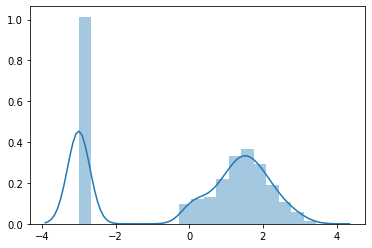

In [16]:
import seaborn as sns

sns.distplot(dataset.load_data(1)['mel'].squeeze().detach().cpu().numpy().T)

# ok the dataset loading melspectrogra with custom padding and padding values is ok

In [ ]:
# Lets dev the similar to Omniglot loader

class SERNShot:
    
    def __init__(self, df_train_path, df_test_path, ap, batch_size, n_way, k_shot, k_query, pad_to = 200, pad_value = -3):
        
        self.df_train_path = df_train_path
        self.df_test_path = df_test_path
        self.ap = ap
        self.pad_to = pad_to
        self.pad_value = pad_value
        self.batchsz = batch_size
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        
        # Used for training, only 2 languages
        self.dataset_train = Dataloader4SER(self.df_train_path, self.ap, pad_to = self.pad_to, pad_value = self.pad_value)
        # Used for fine-tuning, the out-of-distribution language
        self.dataset_test = Dataloader4SER(self.df_test_path, self.ap, pad_to = self.pad_to, pad_value = self.pad_value)
        
        self.length = self.pad_to
        self.mel_dim = self.ap.num_mels
        
        x = self.dataset_train.x
        y = self.dataset_train.y
        
        x_test = self.dataset_test.x
        y_test = self.dataset_test.y
        
        temp = dict()
        
        for i in range(len(x)):
            if(y[i] in temp.keys()):
                temp[y[i]].append(self.dataset_train.load_data(i)['mel'].detach().numpy())
            else:
                temp[y[i]] = [self.dataset_train.load_data(i)['mel'].detach().numpy()]
                
        self.data = [] # It will be a [classes, mspec] array
        for label, mspec in temp.items():
            self.data.append(np.array(mspec))
        
        temp = dict()
        
        for i in range(len(x_test)):
            if(y_test[i] in temp.keys()):
                temp[y_test[i]].append(self.dataset_test.load_data(i)['mel'].detach().numpy())
            else:
                temp[y_test[i]] = [self.dataset_test.load_data(i)['mel'].detach().numpy()]
                
        self.test_data = [] # It will be a [classes, mspec] array
        for label, mspec in temp.items():
            self.test_data.append(np.array(mspec))
        
        self.data = np.array(self.data)
        self.test_data = np.array(self.test_data)
        
        # Verbose
        print(f"There are {len(self.data)} samples for training and {len(self.test_data)} for out-of-distribution language.")
        
        
        self.n_cls_train = self.data.shape[0]
        self.n_cls_test = self.test_data.shape[0]
        
        # Verbose 
        print(f"n_class train = {self.n_cls_train} | n_class test = {self.n_cls_test}")
        
        # Pointer of current read batch
        self.indexes = {'train': 0, 'test': 0}
        self.datasets = {'train': self.data, 'test': self.test_data}
        
        self.datasets_cache = {"train": self.load_data_cache(self.datasets["train"]),  # current epoch data cached
                               "test": self.load_data_cache(self.datasets["test"])}
        
    def load_data_cache(self, data_pack):
        """
        Collects several batches data for N-shot learning
        :param data_pack: [cls_num, 20, 84, 84, 1]
        :return: A list with [support_set_x, support_set_y, target_x, target_y] ready to be fed to our networks
        """
        #  take 5 way 1 shot as example: 5 * 1
        setsz = self.k_shot * self.n_way
        querysz = self.k_query * self.n_way
        data_cache = []

        # print('preload next 50 caches of batchsz of batch.')
        for sample in range(10):  # num of episodes

            x_spts, y_spts, x_qrys, y_qrys = [], [], [], []
            for i in range(self.batchsz):  # one batch means one set

                x_spt, y_spt, x_qry, y_qry = [], [], [], []
                selected_cls = np.random.choice(data_pack.shape[0], self.n_way, False)

                for j, cur_class in enumerate(selected_cls):
                    
                    # Get min size over all classes as our min_sample to random select k_shot + k_query examples
                    min_samples = np.min([s.shape[0] for s in data_pack])
                    selected_img = np.random.choice(min_samples, self.k_shot + self.k_query, False)

                    # meta-training and meta-test
                    x_spt.append(data_pack[cur_class][selected_img[:self.k_shot]])
                    x_qry.append(data_pack[cur_class][selected_img[self.k_shot:]])
                    y_spt.append([j for _ in range(self.k_shot)])
                    y_qry.append([j for _ in range(self.k_query)])

                # shuffle inside a batch
                perm = np.random.permutation(self.n_way * self.k_shot)
#                 x_spt = np.array(x_spt).reshape(self.n_way * self.k_shot, 1, self.resize, self.resize)[perm]
                x_spt = np.array(x_spt).reshape(self.n_way * self.k_shot, 1, self.length, self.mel_dim)[perm]
                y_spt = np.array(y_spt).reshape(self.n_way * self.k_shot)[perm]
                perm = np.random.permutation(self.n_way * self.k_query)
#                 x_qry = np.array(x_qry).reshape(self.n_way * self.k_query, 1, self.resize, self.resize)[perm]
                x_qry = np.array(x_qry).reshape(self.n_way * self.k_query, 1, self.length, self.mel_dim)[perm]
                y_qry = np.array(y_qry).reshape(self.n_way * self.k_query)[perm]

                # append [sptsz, 1, 84, 84] => [b, setsz, 1, 84, 84]
                x_spts.append(x_spt)
                y_spts.append(y_spt)
                x_qrys.append(x_qry)
                y_qrys.append(y_qry)


            # [b, setsz, 1, 84, 84]
#             x_spts = np.array(x_spts).astype(np.float32).reshape(self.batchsz, setsz, 1, self.resize, self.resize)
            x_spts = np.array(x_spts).astype(np.float32).reshape(self.batchsz, setsz, 1, self.length, self.mel_dim)
            y_spts = np.array(y_spts).astype(np.int).reshape(self.batchsz, setsz)
            # [b, qrysz, 1, 84, 84]
#             x_qrys = np.array(x_qrys).astype(np.float32).reshape(self.batchsz, querysz, 1, self.resize, self.resize)
            x_qrys = np.array(x_qrys).astype(np.float32).reshape(self.batchsz, querysz, self.length, self.mel_dim)
            y_qrys = np.array(y_qrys).astype(np.int).reshape(self.batchsz, querysz)

            data_cache.append([x_spts, y_spts, x_qrys, y_qrys])

        return data_cache

    def next(self, mode='train'):
        """
        Gets next batch from the dataset with name.
        :param mode: The name of the splitting (one of "train", "val", "test")
        :return:
        """
        # update cache if indexes is larger cached num
        if self.indexes[mode] >= len(self.datasets_cache[mode]):
            self.indexes[mode] = 0
            self.datasets_cache[mode] = self.load_data_cache(self.datasets[mode])

        next_batch = self.datasets_cache[mode][self.indexes[mode]]
        self.indexes[mode] += 1

        return next_batch

In [ ]:
nshot = SERNShot(df_train_path = 'df.csv', df_test_path = 'df.csv', ap = ap, batch_size = 2, n_way = 5, k_shot = 1, k_query = 1, pad_to = 200, pad_value = -3)

In [ ]:
x_spt, y_spt, x_qry, y_qry = nshot.next('train')

In [ ]:
y_spt , y_qry

In [ ]:
x_spt.shape

In [ ]:
sizes = []
for v in nshot.data:
    size_1 = v.shape[0]
    sizes.append(size_1)

In [ ]:
np.min(sizes)